In [1]:
import sys
sys.path.insert(0, "../src")

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import numpy as np
import xarray

import stats 

In [106]:
import inspect
lines = inspect.getsource(stats.compute_xcor_nd)
print(lines)

def compute_xcor_nd(Z1, Z2, lag=0):
    """
    Empirical cross-correlation broadcasted over an array
    Cressie and Wikle, Eq 5.4, single location.
    Inputs:
        - Z1, Z2: xarray data array (lon x lat x time)
        - lag: integer lag
    Outputs:
        - xcor: xarray data array (lon x lat)
    """
    # apply mask for nan values
    Z1_m = np.ma.array(Z1, mask=np.isnan(Z1))
    Z2_m = np.ma.array(Z2, mask=np.isnan(Z2))

    # remove the mean along time dim
    X = Z1_m - Z1_m.mean(axis=-1, keepdims=True)
    Y = Z2_m - Z2_m.mean(axis=-1, keepdims=True)
    if lag is not 0:
        # truncate along time dim at appropriate position to apply lag
        X = X[:, :, lag:]
        Y = Y[:, :, :-lag]

    # compute cross-correlation along the time dimension
    xcor = np.mean(X * Y, axis=-1) / np.sqrt(X.var(axis=-1) * Y.var(axis=-1))

    # return data values with missing entries filled as nan
    return np.ma.filled(xcor.astype(float), np.nan)



In [118]:
def gen_1d_arr(N):
    # Create a random 1-d array with ~1/3 of the entries missing
    idx = np.random.choice(np.arange(N), size=int(N / 3), replace=False)
    X = np.random.rand(N)
    X[idx] = np.nan
    return X

def gen_nd_arr(N):
    # Create a random 3-d array with ~1/3 of the entries missing
    idx = np.random.choice(np.arange(N**3), size=int(N**3 / 2  + N**2), replace=False)
    X = np.random.rand(N**3)
    X[idx] = np.nan
    return X.reshape(N, N, N)

In [62]:
X = gen_nd_arr(100)

DS = xarray.Dataset(
    {
        "sif": (["lon", "lat", "time"], X),
        "xco2": (["lon", "lat", "time"], X),
    },
    coords = {
        "lon": (["lon"], np.arange(100)),
        "lat": (["lat"], np.arange(100)),
        "time": (["time"], np.arange(100)),
    }
)

DS

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 100, time: 100)
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    sif      (lon, lat, time) float64 0.3506 0.9523 0.2547 ... 0.568 0.8688 nan
    xco2     (lon, lat, time) float64 0.3506 0.9523 0.2547 ... 0.568 0.8688 nan

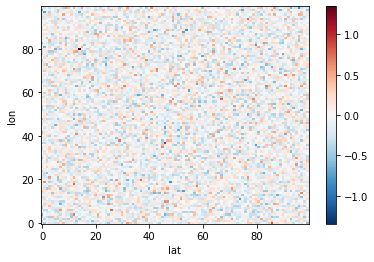

In [112]:
xcor = stats.apply_xcor(DS.xco2, DS.sif, lag=10)
xcor.plot()

In [113]:
xcor.max()

<xarray.DataArray ()>
array(1.34707934)

In [114]:
xcor = stats.compute_xcor_nd(DS.xco2, DS.sif, lag=10)

In [116]:
xcor.max()

1.296353522837143

In [127]:
# Check the 1-d case
x_list = [gen_1d_arr(100) for _ in range(100)]

xcor = np.array([stats.compute_xcor_1d(x, x, lag=10) for x in x_list])
xcor

array([-0.10371285,  0.04722152,  0.02991988, -0.02805042, -0.12342185,
       -0.1074257 , -0.05759522, -0.05568164, -0.01846074, -0.04122928,
       -0.01758189,  0.094552  ,  0.08435446, -0.03743599, -0.20637162,
        0.14787288,  0.06055466, -0.16426138,  0.21449664,  0.01292171,
       -0.36273864, -0.16519087,  0.23026614,  0.15519176,  0.16952758,
       -0.19898085, -0.03377582, -0.06371112,  0.26567487, -0.07572662,
       -0.08970469, -0.19850789, -0.20695873,  0.0220576 , -0.13567128,
       -0.27616877,  0.14312647,  0.03707459,  0.1395008 , -0.05399985,
        0.01992762,  0.07867313,  0.21304517, -0.13477816,  0.14518823,
        0.10693435,  0.04740621, -0.07672688,  0.05108388,  0.17528686,
        0.01916204, -0.43680341,  0.01732409,  0.06109714, -0.35395466,
       -0.15557624,  0.02537344, -0.05729799,  0.01790003,  0.18165816,
        0.17576577,  0.06687235, -0.12492986,  0.10488331,  0.10313806,
        0.08057394,  0.20876957, -0.13843525, -0.04915988, -0.00

In [130]:
xcor.min()

-0.4368034102713942

In [ ]:
# Repeat the above but using 1-d masked arrays (write new compute function)